In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

from joblib import Parallel

from useful_func import *


from skimage.transform import rescale, resize, downscale_local_mean
import skimage
from scipy.ndimage import binary_erosion


import tifffile as tiff
from tqdm import tqdm

sigma_480 = 198 #m2/mol
sigma_405 = 415 #m2/mol
tau_relax = 0.014

import click

from alienlab.plot import PlotFigure
p = PlotFigure()
p.save_folder = "G:/DREAM/from_github/thesis/Intensity_paper/"
p.extension = ".pdf"

#%matplotlib widget

In [2]:
folder= "../data/macroimager/"
list_names = ["fps5_blue4_60pm", "fps4_blue4_60pm_2", "fps2_blue5_60pm_1led_expo500ms_cuve", "fps2_blue5_60pm_1led_expo500ms_petri35mm", "fps2_blue5_60pm_1over2led_expo400ms_petri35mm", 
              "fps2_blue5_60pm_1over4led_expo400ms_petri35mm", "fps2_blue5_60pm_all_led_expo250ms_petri35mm",
             "fps2_blue5_120pm_1led_expo500ms_petri35mm_1", "fps2_blue5_120pm_1led_expo500ms_petri35mm_2", 
             "fps4_blue4_60pm_1led_2", "fps4_blue4_120pm_1led_2", "fps4_blue4_120pm_2", "fps5_blue4_120pm"]
filename = list_names[4]
file = folder + filename
if os.path.isfile(file):
    video = tiff.imread(file)
    
elif os.path.isdir(file):
    video = []
    ref = glob.glob(file + "/*.tif")
    shape = np.shape(tiff.imread(ref[0]))
    for im in tqdm(ref):
        image = tiff.imread(im)
        #if image.shape == shape:
        video.append(image)
    video = np.array(video)
    
else:
    print('wrong path')
    
    


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:08<00:00, 19.58it/s]


In [3]:
dx = int(video.shape[1]*(1-606/660)//2)
video = video[:,dx:-dx]

In [4]:
framerate = int(filename[3])


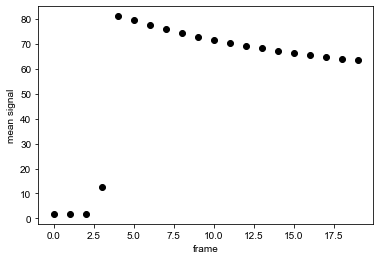

In [5]:
plt.xlabel('frame')
plt.ylabel('mean signal')
plt.plot(np.mean(video[0:20], axis = (1,2)), "ko")

1.0949148029818958


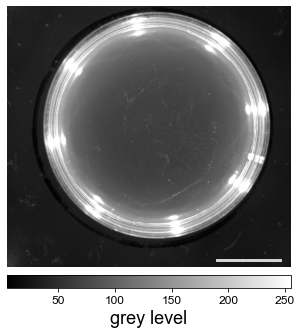

In [6]:


ref = 5#click.prompt("First useful frame", type=int, default=0)

p.set_figure()
plt.axis("off")
image = plt.imshow(video[ref], cmap = "gray")

H, L = video[ref].shape
#rec = matplotlib.patches.Rectangle((H-5*H//6, L-4*L//7), H//6*4.8, L//100, color = "lightgrey")
ratio = 3.5/(H//6*4.8)
scale = H//4
rec = matplotlib.patches.Rectangle((H-H//5, L-L//9), scale, L//100, color = "lightgrey")
ax = plt.gca()
ax.add_patch(rec)

divider = make_axes_locatable(plt.gca())
axdef = divider.append_axes("bottom", "5%", pad="3%")
cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
ax = plt.gca()
plt.xlabel("grey level", size=p.fontsize)

ax.tick_params(labelsize=p.fonttick)

plt.savefig(p.save_folder + "/" + filename + "_intensity" + p.extension)

print(ratio*scale)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


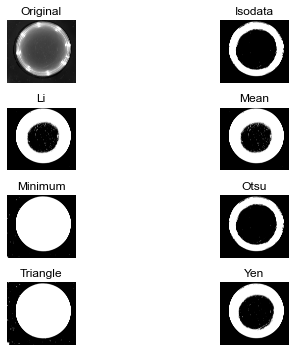

In [7]:
u = skimage.filters.try_all_threshold(video[ref])


In [8]:
threshold_method = threshold_convert("skimage.filters.thresholding.threshold_triangle")

#click.prompt("copy the name of the thresholding method that suits you. If none suits, enter None", type = str, default="skimage.filters.thresholding.threshold_minimum"))


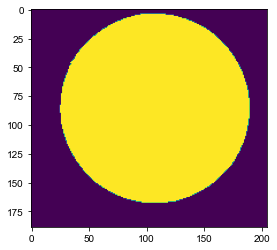

In [9]:
D = 10# click.prompt("smoothing & downscaling factor to accelerate computations", type=int, default=5)

video = np.array(video)
timing = np.linspace(0, len(video)-1, len(video))/framerate #generate time array from framerate
mask = downscale_local_mean(video[ref], (D,D))
threshold = threshold_method(mask)

mask = mask>threshold
mask = skimage.morphology.binary_opening(mask)
mask[:, 0:15] = 0

plt.imshow(mask)




#downscaling 
video_downscaled = []
for i in range(ref, video.shape[0]):
    video_downscaled.append(downscale_local_mean(video[i], (D, D)))
video_downscaled = np.array(video_downscaled)
init_shape = np.copy(video_downscaled.shape)
L, H = init_shape[1:]
video_2D = np.copy(video_downscaled)
video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)

to_evaluate = video_downscaled[:,mask.flatten()]

In [10]:
timing.shape

(168,)

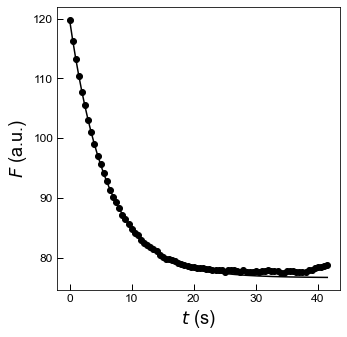

In [11]:
stop = len(video)//2 #<------ you can select a shorter segment for the fits
#fit on the mean value before performing the fit on each pixel
timing = np.linspace(0, stop - 1, stop)/framerate

params = simple_tau(np.mean(to_evaluate[0:stop], axis = 1), timing[0:stop], sample_rate = framerate)

fig = p.set_figure("%d", "%d")
time = timing[0:stop]
time -= time[0]
plt.plot(time, np.mean(to_evaluate[0:stop], axis = 1), "ok", label = "raw data")

x2 = np.linspace(time.min(), time.max(), 1024)
plt.plot(x2, exp_decay(params, x2), "k", label = "fit")

plt.xlabel('$t$ (s)')
plt.ylabel("$F$ (a.u.)")
#plt.legend()
plt.savefig(p.save_folder + filename + "_mean_decay_fit_D2.pdf")

In [12]:
sat = np.sum(to_evaluate[ref]==255)/len(to_evaluate[ref].flatten())*100
print("percent of saturated pixels in the mask: ", sat)

if sat > 2:
    print("WARNING, more than 2% of the pixels are saturated on the first frame, try acquiring the movie with shorter exposure/smaller gain.")

percent of saturated pixels in the mask:  1.2144605535680661


In [13]:
#parallel fit on each pixel of the mask
tau_lists = Parallel(n_jobs = -1 )(parallel_tau(to_evaluate[0:stop,i], timing[0:stop], sample_rate = framerate) for i in tqdm(range(to_evaluate.shape[1])))


100%|██████████████████████████████████████████████████████████████████████████| 21244/21244 [00:11<00:00, 1900.84it/s]


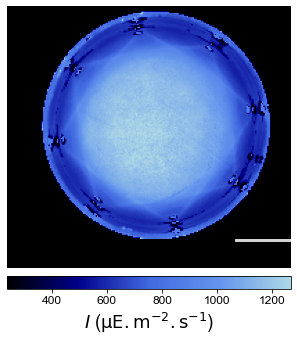

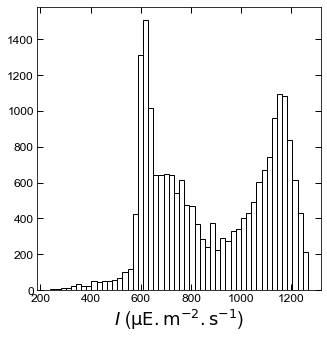

In [14]:
tau_480 = np.array(tau_lists)
tau_480_map = np.zeros(mask.shape)
tau_480_map[mask] = tau_480


I_480 = 1e6*(1/tau_480 - tau_relax)/sigma_480
I_480_map = np.zeros(mask.shape)
I_480_map[mask] = I_480
I_480_map[I_480_map<0]  = 0


np.save("../images/I_480_map.npy", I_480_map)

plt.rcParams['image.cmap'] = 'viridis'


 
I, dis, fig = plot_map(I_480, I_480_map,filename + "_I_480_map_B" + p.extension)

np.save("../images/video_2D.npy", video_2D)
np.save("../images/framerate.npy", framerate)


In [35]:
p.save_folder

'G:/DREAM/from_github/thesis/Intensity_paper/'

## Ian exp

In [32]:
folder = "../data/macroimager/macro_ian/"

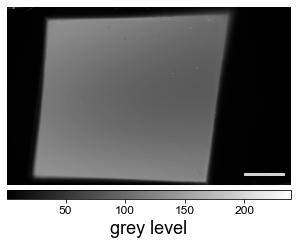

In [34]:
filename = "MacroIllumination_FirstImageInDecay_Greyscale"
data0 = np.load(folder + filename + ".npy")

p.set_figure()
plt.axis("off")
image = plt.imshow(data0, cmap = "gray")

L, H = data0.shape
#rec = matplotlib.patches.Rectangle((H-5*H//6, L-4*L//7), H//6*4.8, L//100, color = "lightgrey")
ratio = 3.5/(H//6*4.8)
scale = H//7
rec = matplotlib.patches.Rectangle((H-H//6, L-L//15), scale, L//100, color = "lightgrey")
ax = plt.gca()
ax.add_patch(rec)

divider = make_axes_locatable(plt.gca())
axdef = divider.append_axes("bottom", "5%", pad="3%")
cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
ax = plt.gca()
plt.xlabel("grey level", size=p.fontsize)

ax.tick_params(labelsize=p.fonttick)

plt.savefig(p.save_folder + "/" + filename + p.extension)

(array([2.54058e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 7.50000e+01, 8.43000e+02, 8.52000e+02, 7.73000e+02,
        7.29000e+02, 7.24000e+02, 6.90000e+02, 7.18000e+02, 6.28000e+02,
        6.80000e+02, 7.03000e+02, 7.22000e+02, 6.96000e+02, 9.15000e+02,
        1.16800e+03, 2.88400e+03, 8.85100e+03, 2.13540e+04, 2.77600e+04,
        2.56630e+04, 2.35210e+04, 2.52100e+04, 2.98570e+04, 2.86360e+04,
        3.05360e+04, 2.81480e+04, 2.80960e+04, 2.19680e+04, 2.10860e+04]),
 array([   0.        ,  136.94059215,  273.88118431,  410.82177646,
         547.76236862,  684.70296077,  821.64355292,  958.58414508,
        1095.52473723, 1232.46532938, 1369.40592154, 1506.34651369,
        1643.28710585, 1780.227698  , 1917.16829015, 2054.108882

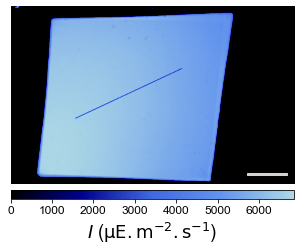

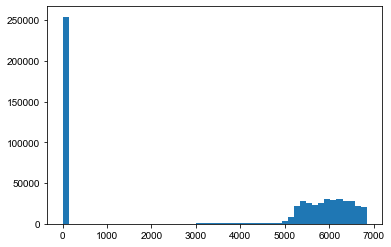

In [46]:
filename = "MacroIllumination_ExperimentalIntensityMap"
data0 = np.load(folder + filename + ".npy")

p.set_figure()
plt.axis("off")
image = plt.imshow(data0, cmap = blue_map)

L, H = data0.shape
#rec = matplotlib.patches.Rectangle((H-5*H//6, L-4*L//7), H//6*4.8, L//100, color = "lightgrey")
ratio = 3.5/(H//6*4.8)
scale = H//7
rec = matplotlib.patches.Rectangle((H-H//6, L-L//15), scale, L//100, color = "lightgrey")
ax = plt.gca()
ax.add_patch(rec)

divider = make_axes_locatable(plt.gca())
axdef = divider.append_axes("bottom", "5%", pad="3%")
cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
ax = plt.gca()
plt.xlabel(p.label_intensity, size=p.fontsize)

ax.tick_params(labelsize=p.fonttick)

plt.savefig(p.save_folder + "/" + filename + p.extension)


plt.figure()
plt.hist(data0.flatten(), bins = 50)

(array([2.54652e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        9.94000e+02, 9.68000e+02, 1.06200e+03, 9.57000e+02, 9.16000e+02,
        1.02700e+03, 1.10100e+03, 1.34600e+03, 1.68800e+03, 3.49500e+03,
        6.24200e+03, 1.03540e+04, 1.64500e+04, 2.19900e+04, 2.51070e+04,
        2.68920e+04, 2.78220e+04, 2.94250e+04, 3.01390e+04, 2.96130e+04,
        2.85750e+04, 2.55980e+04, 2.01990e+04, 1.31080e+04, 5.91600e+03,
        2.24500e+03, 5.32000e+02, 1.09000e+02, 1.60000e+01, 6.00000e+00]),
 array([   0.        ,  149.18531765,  298.37063529,  447.55595294,
         596.74127059,  745.92658824,  895.11190588, 1044.29722353,
        1193.48254118, 1342.66785882, 1491.85317647, 1641.03849412,
        1790.22381176, 1939.40912941, 2088.59444706, 2237.779764

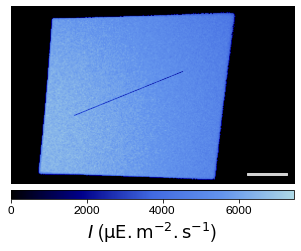

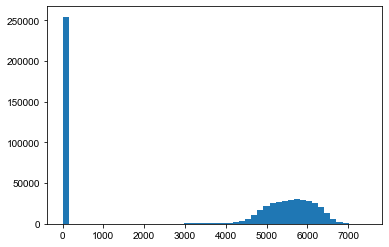

In [45]:
filename = "MacroIllumination_SimulatedIntensityMap"
data0 = np.load(folder + filename + ".npy")

p.set_figure()
plt.axis("off")
image = plt.imshow(data0, cmap = blue_map)

L, H = data0.shape
#rec = matplotlib.patches.Rectangle((H-5*H//6, L-4*L//7), H//6*4.8, L//100, color = "lightgrey")
ratio = 3.5/(H//6*4.8)
scale = H//7
rec = matplotlib.patches.Rectangle((H-H//6, L-L//15), scale, L//100, color = "lightgrey")
ax = plt.gca()
ax.add_patch(rec)

divider = make_axes_locatable(plt.gca())
axdef = divider.append_axes("bottom", "5%", pad="3%")
cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
ax = plt.gca()
plt.xlabel(p.label_intensity, size=p.fontsize)

ax.tick_params(labelsize=p.fonttick)

plt.savefig(p.save_folder + "/" + filename + p.extension)

plt.figure()
plt.hist(data0.flatten(), bins = 50)

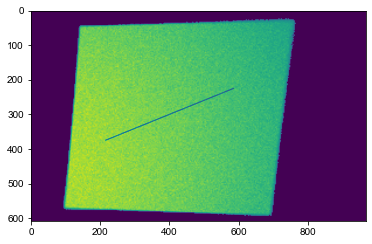

In [19]:
data = np.load("../data/macroimager/macro_ian/MacroIllumination_SimulatedIntensityMap.npy")
plt.imshow(data)

In [41]:
p.fontsize

18

In [42]:
p.fonttick

12